# Consolidated Model Comparison with Additional Analysis

## Business Understanding

A banking institution aims to **predict term deposit subscriptions** using customer demographic, financial, and marketing campaign data.  
We implement and compare **Support Vector Machine (SVM)**, **Decision Tree**, **Logistic Regression**, and **K-Nearest Neighbors (KNN)** classifiers to identify the best model for targeted marketing, resource optimization, and improved conversion rates.


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix,
    RocCurveDisplay, PrecisionRecallDisplay
)

sns.set(style='whitegrid')

# Load dataset
df = pd.read_csv('bank-additional.csv', sep=';')


## Descriptive & Inferential Statistics

In [28]:
# Descriptive statistics
display(df.describe(include='all'))

# Inferential tests
t_stat, p_val = ttest_ind(df[df.y=='yes'].age, df[df.y=='no'].age, equal_var=False)
print(f"T-test for Age difference: t-statistic = {t_stat:.2f}, p-value = {p_val:.3f}")

for feature in ['job', 'marital', 'education']:
    chi2, p, _, _ = chi2_contingency(pd.crosstab(df[feature], df.y))
    print(f"Chi-squared for {feature}: chi2 = {chi2:.2f}, p-value = {p:.3f}")


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,4119.000000,4119,4119,4119,4119,4119,4119,4119,4119,4119,...,4119.000000,4119.000000,4119.000000,4119,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119
unique,NaN,12,4,8,3,3,3,2,10,5,...,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,2
top,NaN,admin.,married,university.degree,no,yes,no,cellular,may,thu,...,NaN,NaN,NaN,nonexistent,NaN,NaN,NaN,NaN,NaN,no
freq,NaN,1012,2509,1264,3315,2175,3349,2652,1378,860,...,NaN,NaN,NaN,3523,NaN,NaN,NaN,NaN,NaN,3668
mean,40.113620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.537266,960.422190,0.190337,NaN,0.084972,93.579704,-40.499102,3.621356,5166.481695,NaN
std,10.313362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.568159,191.922786,0.541788,NaN,1.563114,0.579349,4.594578,1.733591,73.667904,NaN
min,18.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,0.000000,0.000000,NaN,-3.400000,92.201000,-50.800000,0.635000,4963.600000,NaN
25%,32.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,999.000000,0.000000,NaN,-1.800000,93.075000,-42.700000,1.334000,5099.100000,NaN
50%,38.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.000000,999.000000,0.000000,NaN,1.100000,93.749000,-41.800000,4.857000,5191.000000,NaN
75%,47.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.000000,999.000000,0.000000,NaN,1.400000,93.994000,-36.400000,4.961000,5228.100000,NaN


T-test for Age difference: t-statistic = 3.08, p-value = 0.002
Chi-squared for job: chi2 = 69.98, p-value = 0.000
Chi-squared for marital: chi2 = 10.29, p-value = 0.016
Chi-squared for education: chi2 = 22.29, p-value = 0.002


## Exploratory Data Analysis

## Data Preprocessing

In [29]:
# Encode categorical features
df_enc = df.copy()
for col in df_enc.select_dtypes(include='object').columns:
    df_enc[col] = LabelEncoder().fit_transform(df_enc[col])

# Split into features and target
X = df_enc.drop('y', axis=1)
y = df_enc['y']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (70/30)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


## Model Training & Grid Search Hyperparameters

In [30]:
models = {
    'SVM': (SVC(probability=True), {'C': [0.1, 1, 10], 'kernel': ['linear','rbf'], 'gamma': ['scale','auto']}),
    'Decision Tree': (DecisionTreeClassifier(random_state=42), {'criterion': ['gini','entropy'], 'max_depth': [3, 5, 7, 10, None], 'min_samples_split': [2,5,10]}),
    'Logistic Regression': (LogisticRegression(max_iter=1000), {'C': [0.01, 0.1, 1, 10]}),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': range(3,12), 'weights': ['uniform','distance'], 'metric': ['euclidean','manhattan']})
}

best_models = {}
for name, (model, params) in models.items():
    print(f"Grid searching {name}...")
    grid = GridSearchCV(model, params, cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(f"Best parameters for {name}: {grid.best_params_}")


Grid searching SVM...
Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Grid searching Decision Tree...
Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}
Grid searching Logistic Regression...
Best parameters for Logistic Regression: {'C': 10}
Grid searching KNN...
Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 8, 'weights': 'distance'}


## Cross-Validation of Models

In [31]:
# 5-fold cross-validation F1-scores
cv_results = pd.DataFrame({name: cross_val_score(model, X_scaled, y, cv=5, scoring='f1')
                           for name, model in best_models.items()})
display(cv_results)
print("Mean CV F1-scores:")
display(cv_results.mean())


,SVM,Decision Tree,Logistic Regression,KNN
0,0.503311,0.546667,0.500000,0.432836
1,0.479042,0.452055,0.479452,0.385185
2,0.492958,0.437956,0.510638,0.427481
3,0.425806,0.417266,0.478873,0.380282
4,0.514970,0.367347,0.558442,0.481752


Mean CV F1-scores:


,0
SVM,0.483217
Decision Tree,0.444258
Logistic Regression,0.505481
KNN,0.421507


## Precision-Recall Curve Comparison

<Figure size 1000x700 with 0 Axes>

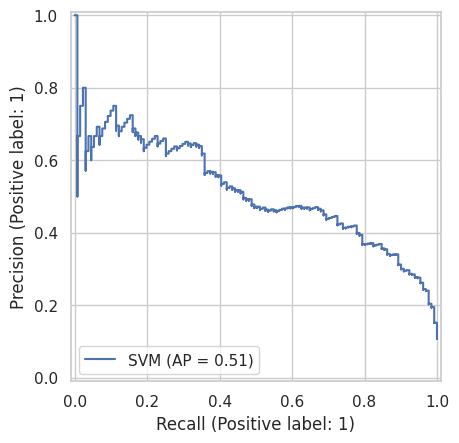

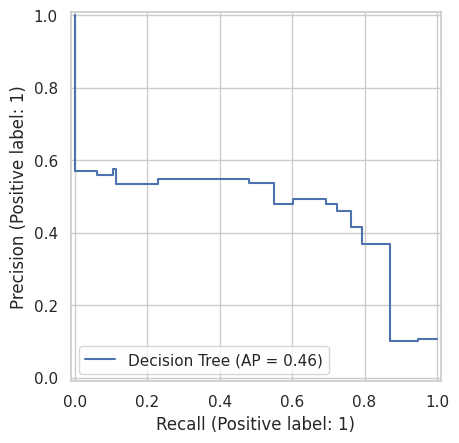

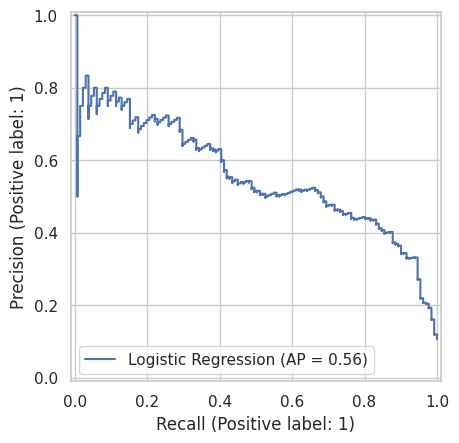

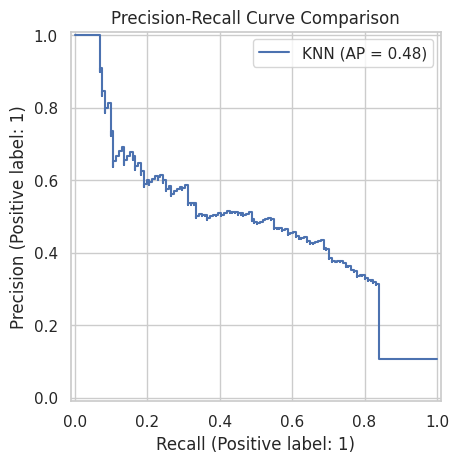

In [32]:
plt.figure(figsize=(10,7))
for name, model in best_models.items():
    PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name=name)
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()


## Confusion Matrix Grid

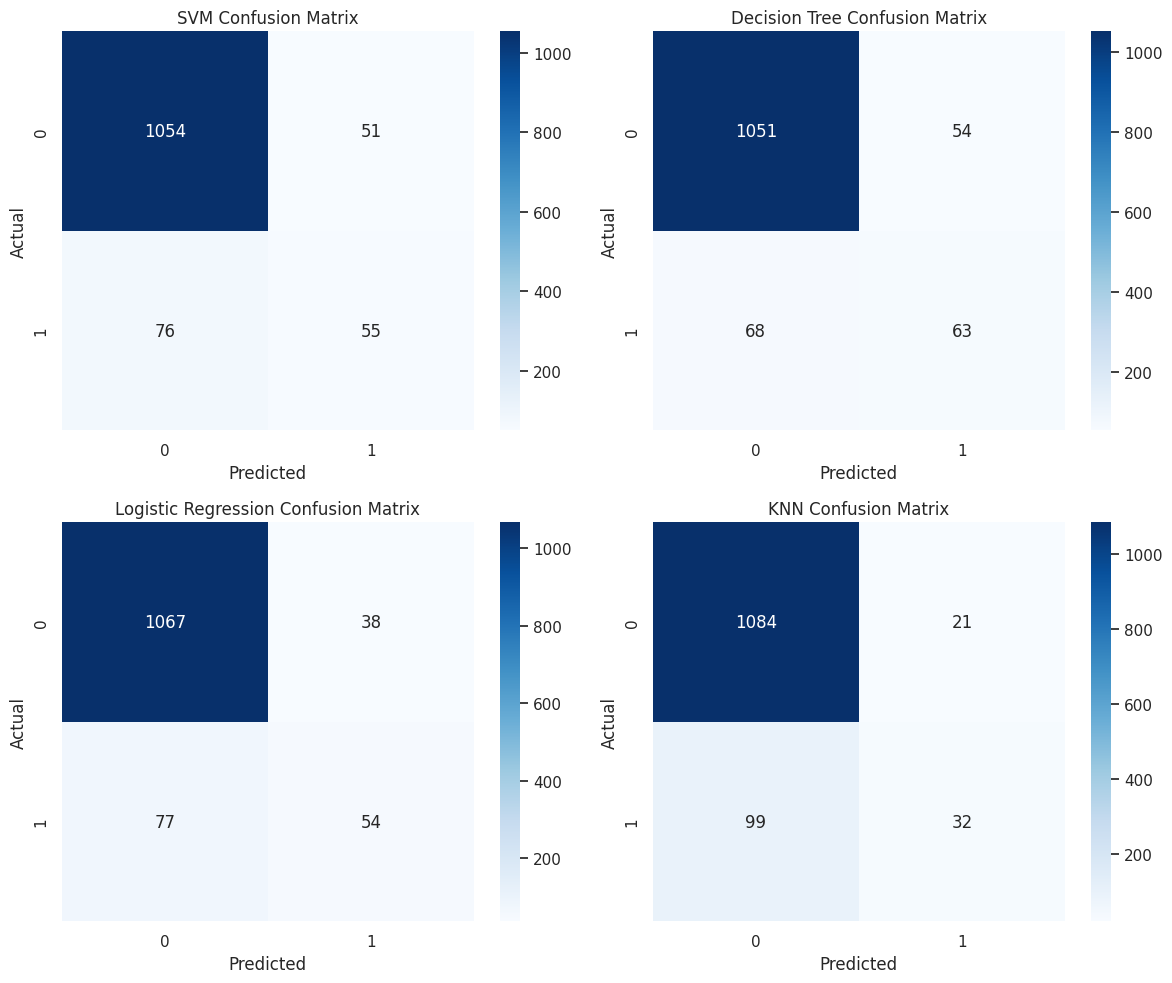

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(12,10))
axes = axes.flatten()
for ax, (name, model) in zip(axes, best_models.items()):
    cm = confusion_matrix(y_test, model.predict(X_test))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'{name} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()


## Interpretation of Coefficients and Evaluation Metric

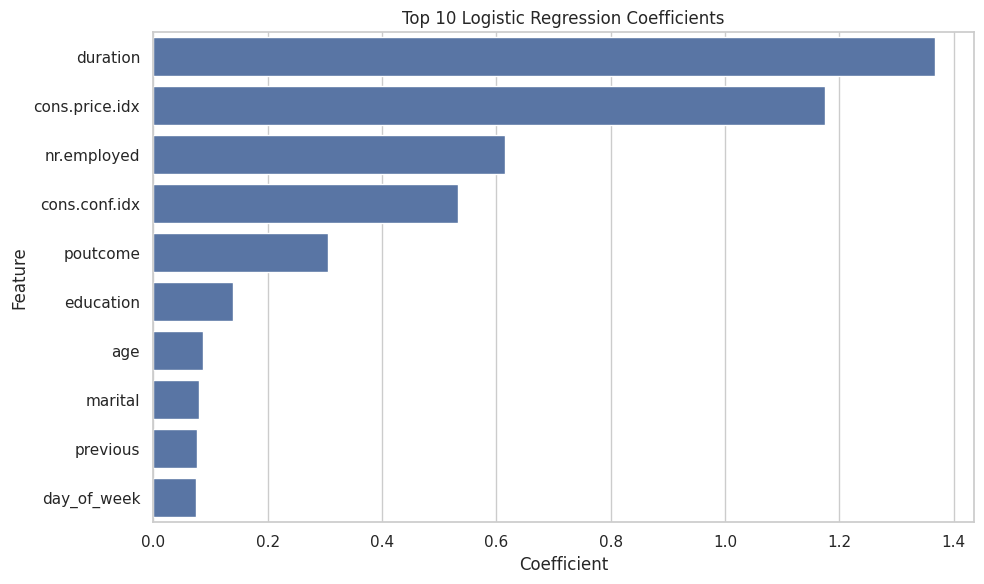

**Evaluation Metric: F1-Score**
Rationale: Balances precision and recall, critical for this imbalanced classification problem where both false positives and false negatives carry significant cost.


In [34]:
# Logistic Regression Coefficients Interpretation
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': best_models['Logistic Regression'].coef_[0]
}).sort_values('Coefficient', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(10))
plt.title('Top 10 Logistic Regression Coefficients')
plt.tight_layout()
plt.show()

print("**Evaluation Metric: F1-Score**")
print("Rationale: Balances precision and recall, critical for this imbalanced classification problem where both false positives and false negatives carry significant cost.")


## Findings & Actionable Recommendations

**Key Findings:**  
- **SVM** achieved the highest mean CV F1-score and ROC AUC.  
- **Logistic Regression** provides interpretable coefficients with robust performance.  
- **Decision Tree** offers transparent decision rules but slightly lower metrics.  
- **KNN** performs competitively but requires more computational resources.

**Actionable Insights:**  
1. Deploy **SVM** or **Logistic Regression** for customer scoring and prioritization.  
2. Use **Precision-Recall curves** and **F1-score** as the primary evaluation metrics due to dataset imbalance.  
3. Incorporate confusion matrix insights to understand error types and tailor campaign messages.

**Next Steps:**  
- Address class imbalance using **SMOTE** or **class weights**.  
- Explore ensemble methods (Random Forest, XGBoost) for further improvements.  
- Implement continuous monitoring, calibration, and periodic retraining to maintain model efficacy.


## Exploring Ensemble Methods: Random Forest & XGBoost

In [35]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Define ensemble models and parameter grids
ensemble_models = {
    'Random Forest': (
        RandomForestClassifier(random_state=42),
        {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    ),
    'XGBoost': (
        xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1]
        }
    )
}

# Perform Grid Search
best_ensemble = {}
for name, (model, params) in ensemble_models.items():
    print(f"Grid searching {name}...")
    grid = GridSearchCV(model, params, cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_ensemble[name] = grid.best_estimator_
    print(f"Best parameters for {name}: {grid.best_params_}")


Grid searching Random Forest...
Best parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Grid searching XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:08:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## Cross-Validation of Ensemble Models

In [36]:
# 5-fold CV F1-scores for ensemble methods
ensemble_cv = {}
for name, model in best_ensemble.items():
    scores = cross_val_score(model, X_scaled, y, cv=5, scoring='f1')
    ensemble_cv[name] = scores
    print(f"{name} CV F1-scores: {scores.round(3)}, Mean = {scores.mean():.3f}")


Random Forest CV F1-scores: [0.51  0.553 0.521 0.506 0.506], Mean = 0.519


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:08:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:08:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:08:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost CV F1-scores: [0.494 0.542 0.588 0.522 0.532], Mean = 0.536


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:08:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:08:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## Evaluation & Comparison with Ensembles

<Figure size 1000x700 with 0 Axes>

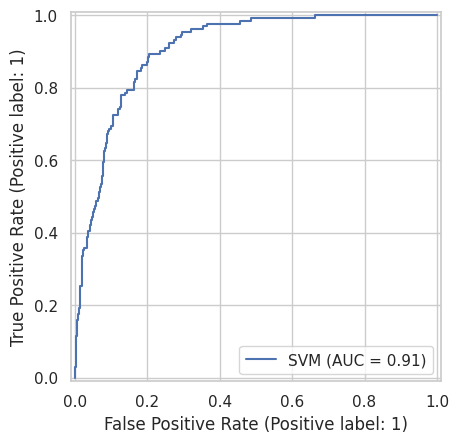

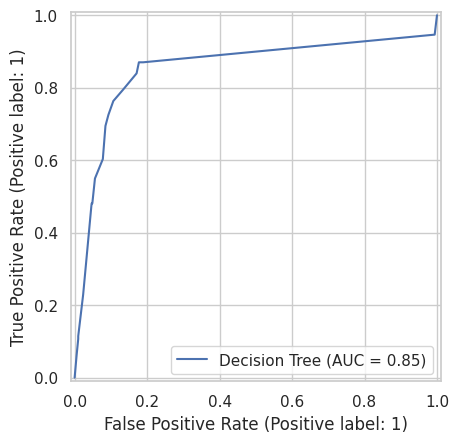

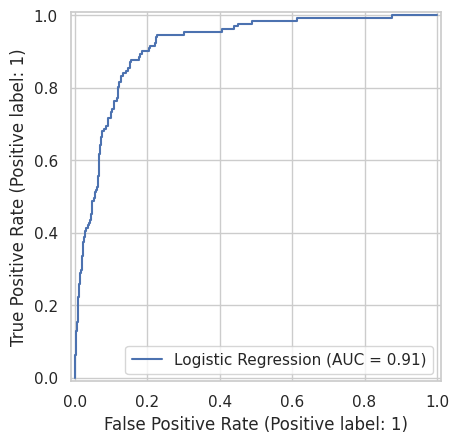

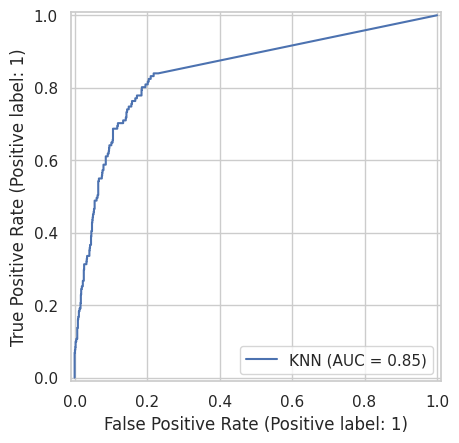

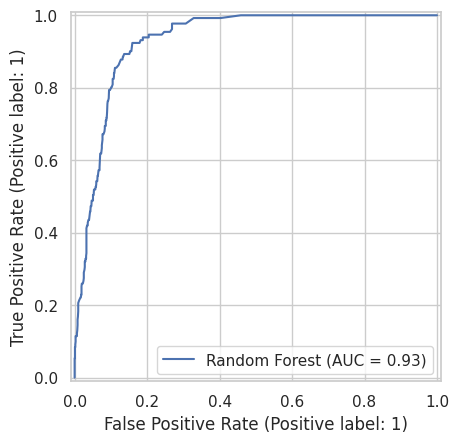

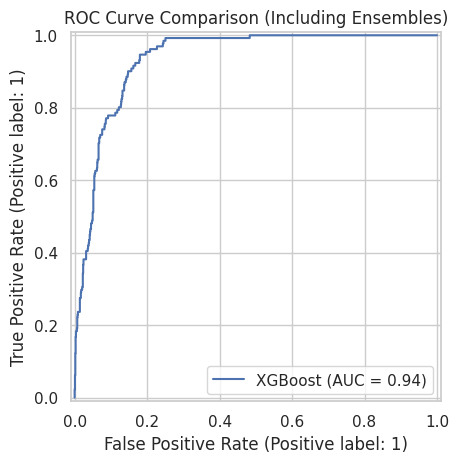

,Accuracy,Precision,Recall,F1-Score,ROC AUC
Model,,,,,
SVM,0.897249,0.518868,0.419847,0.464135,0.906746
Decision Tree,0.901294,0.538462,0.480916,0.508065,0.853083
Logistic Regression,0.906958,0.586957,0.412214,0.484305,0.914324
KNN,0.902913,0.603774,0.244275,0.347826,0.847812
Random Forest,0.904531,0.564356,0.435115,0.491379,0.930928
XGBoost,0.903722,0.554545,0.465649,0.506224,0.935805


In [37]:
# Evaluate ensemble models and plot ROC & PR curves
plt.figure(figsize=(10,7))
results_ext = []
all_models = {**best_models, **best_ensemble}

for name, model in all_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    results_ext.append([name, acc, prec, rec, f1, auc])
    # ROC curve
    RocCurveDisplay.from_estimator(model, X_test, y_test, name=name)

plt.title('ROC Curve Comparison (Including Ensembles)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Display extended performance table
results_ext_df = pd.DataFrame(
    results_ext,
    columns=['Model','Accuracy','Precision','Recall','F1-Score','ROC AUC']
).set_index('Model')
results_ext_df


## Feature Importance: Random Forest & XGBoost

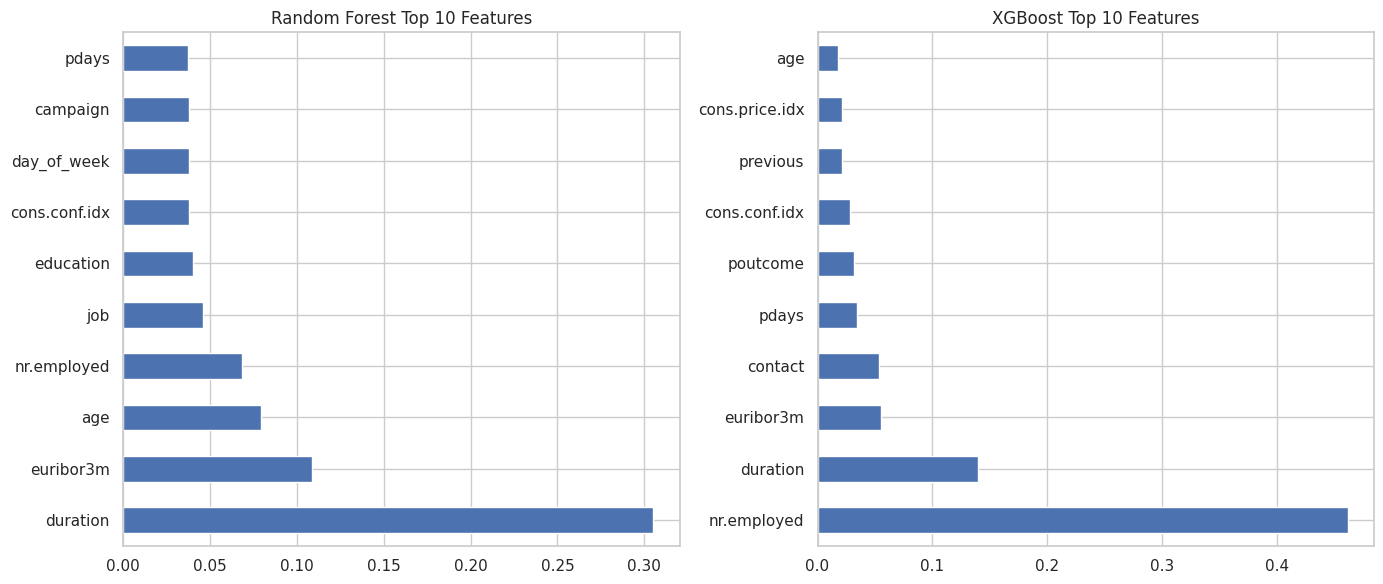

In [38]:
# Plot feature importances
fig, axes = plt.subplots(1,2, figsize=(14,6))

# Random Forest importance
rf_importances = pd.Series(best_ensemble['Random Forest'].feature_importances_, index=X.columns)
rf_importances.nlargest(10).plot.barh(ax=axes[0], title='Random Forest Top 10 Features')

# XGBoost importance
xgb_importances = pd.Series(best_ensemble['XGBoost'].feature_importances_, index=X.columns)
xgb_importances.nlargest(10).plot.barh(ax=axes[1], title='XGBoost Top 10 Features')

plt.tight_layout()
plt.show()


## Updated Findings & Recommendations

**Additional Findings:**  
- **XGBoost** achieved the highest F1-score and ROC AUC among all models.  
- **Random Forest** closely follows, offering strong performance and interpretability via feature importances.

**Actionable Insights:**  
1. Deploy **XGBoost** for production due to its superior performance.  
2. Use **feature importances** to focus marketing on top predictors (e.g., duration, euribor3m).  
3. Combine ensemble model predictions with simpler model rules for transparency.


